In [91]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import bnlearn as bn
# from pgmpy.models import BayesianNetwork
# from pgmpy.estimators import MaximumLikelihoodEstimator
from causalnex.structure.notears import from_pandas
from causalnex.network import BayesianNetwork
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
lemis = pd.read_csv("lemis_imports_exports.csv").iloc[:, 1:]
lemis.shape

(5569636, 32)

In [3]:
lemis.head()

species_code    genus  species          sub_species          specific_name  \
0         AAA?  ASTRAEA  SPECIES  unknown_sub_species  unknown_specific_name   
1         AAA?  ASTRAEA  SPECIES  unknown_sub_species  unknown_specific_name   
2         AAA?  ASTRAEA  SPECIES  unknown_sub_species  unknown_specific_name   
3         AAA?  ASTRAEA  SPECIES  unknown_sub_species  unknown_specific_name   
4         AAA?  ASTRAEA  SPECIES  unknown_sub_species  unknown_specific_name   

  generic_name disposition_date shipment_date import_export  \
0        SHELL       2005-01-13    2005-01-05             I   
1        SHELL       2005-01-18    2005-01-18             E   
2        SHELL       2005-01-26    2005-01-12             I   
3        SHELL       2005-01-26    2005-01-17             I   
4        SHELL       2005-02-15    2005-02-15             E   

           transport_mode_value  ... grams kilograms liters meters milligrams  \
0  unknown_transport_mode_value  ...   NaN       NaN    NaN    NaN        NaN   
1              Personal vehicle  ...   NaN       NaN    NaN    NaN        NaN   
2  unknown_transport_mode_value  ...   NaN       NaN    NaN    NaN        NaN   
3  unknown_transport_mode_value  ...   NaN       NaN    NaN    NaN        NaN   
4              Personal vehicle  ...   NaN       NaN    NaN    NaN        NaN   

  milliliters number_of_specimens square_centimeter square_meters  \
0         NaN              1157.0               NaN           NaN   
1         NaN                 NaN               NaN           NaN   
2         NaN                 NaN               NaN           NaN   
3         NaN                 NaN               NaN           NaN   
4         NaN                 NaN               NaN           NaN   

   unknown_unit_value  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  

[5 rows x 32 columns]

In [4]:
lemis['disposition_date'] = pd.to_datetime(lemis['disposition_date'])
lemis['shipment_date'] = pd.to_datetime(lemis['shipment_date'])

In [5]:
lemis_2015 = lemis[(lemis['shipment_date'] >= '2015-01-01') & (lemis['shipment_date'] <= '2015-12-31')]

In [6]:
lemis_2015.import_export.value_counts()

I    413273
E     87793
Name: import_export, dtype: int64

In [7]:
imports = lemis_2015[lemis_2015['import_export'] == 'I']
exports = lemis_2015[lemis_2015['import_export'] == 'E']

In [8]:
imports[['country_origin_value', 'country_import_export_value']]

country_origin_value country_import_export_value
257                   Mexico                      Mexico
259                   Mexico                      Mexico
447                Indonesia                   Indonesia
448                   Brazil                      Brazil
449                Indonesia                   Indonesia
...                      ...                         ...
5569223                India                       India
5569245                India                       India
5569307            Australia                   Australia
5569310                 Peru                        Peru
5569627          Afghanistan                 Afghanistan

[413273 rows x 2 columns]

In [9]:
exports[['country_origin_value', 'country_import_export_value']]

country_origin_value country_import_export_value
536                    Indonesia                   Hong Kong
2708                   Indonesia                      Mexico
2720                   Indonesia                       Chile
2751                   Indonesia                      Mexico
2756                   Indonesia                       Chile
...                          ...                         ...
5569565  Ireland, northern (G3*)        United Arab Emirates
5569566                    Italy        United Arab Emirates
5569567           Scotland (G4*)        United Arab Emirates
5569568     United Kingdom (G5*)        United Arab Emirates
5569569              Wales (G6*)        United Arab Emirates

[87793 rows x 2 columns]

In [10]:
imports = imports.rename(columns={'country_import_export_value': 'country_intermediate_value'})
imports['country_destination_value'] = 'United States'

exports = exports.rename(columns={'country_import_export_value': 'country_destination_value'})
exports['country_intermediate_value'] = 'United States'

In [11]:
lemis_country_chain_2015 = pd.concat([imports, exports])
lemis_country_chain_2015 = lemis_country_chain_2015[lemis_country_chain_2015['disposition_value'] != 'unknown_disposition_value']
lemis_country_chain_2015['final_disposition'] = np.where(lemis_country_chain_2015['disposition_value'] == 'Cleared', 'Cleared', 'Refused')
lemis_country_chain_2015.head()

species_code        genus    species          sub_species  \
257         AAA?      ASTRAEA    SPECIES  unknown_sub_species   
259         AAA?      ASTRAEA    SPECIES  unknown_sub_species   
447         AABF  APTERONOTUS  ALBIFRONS  unknown_sub_species   
448         AABF  APTERONOTUS  ALBIFRONS  unknown_sub_species   
449         AABF  APTERONOTUS  ALBIFRONS  unknown_sub_species   

             specific_name generic_name disposition_date shipment_date  \
257  unknown_specific_name        SHELL       2015-01-30    2015-01-30   
259  unknown_specific_name        SHELL       2015-02-27    2015-02-27   
447            APTERONOTID          EEL       2015-01-15    2015-01-15   
448            APTERONOTID          EEL       2015-01-16    2015-01-16   
449            APTERONOTID          EEL       2015-01-22    2015-01-22   

    import_export                 transport_mode_value  ... liters meters  \
257             I  Truck (or other commercial vehicle)  ...    NaN    NaN   
259             I  Truck (or other commercial vehicle)  ...    NaN    NaN   
447             I                            Air cargo  ...    NaN    NaN   
448             I                            Air cargo  ...    NaN    NaN   
449             I                            Air cargo  ...    NaN    NaN   

    milligrams milliliters number_of_specimens square_centimeter  \
257        NaN         NaN                 NaN               NaN   
259        NaN         NaN                 NaN               NaN   
447        NaN         NaN                18.0               NaN   
448        NaN         NaN                15.0               NaN   
449        NaN         NaN                26.0               NaN   

    square_meters unknown_unit_value country_destination_value  \
257           NaN                NaN             United States   
259           NaN                NaN             United States   
447           NaN                NaN             United States   
448           NaN                NaN             United States   
449           NaN                NaN             United States   

     final_disposition  
257            Cleared  
259            Cleared  
447            Cleared  
448            Cleared  
449            Cleared  

[5 rows x 34 columns]

In [12]:
lemis_country_chain_2015.disposition_value.value_counts()

Cleared      492810
Seized         4406
Reexport       2489
Abandoned      1354
Name: disposition_value, dtype: int64

In [13]:
lemis_country_chain_2015.final_disposition.value_counts()

Cleared    492810
Refused      8249
Name: final_disposition, dtype: int64

In [14]:
lemis_country_chain_2015.columns

Index(['species_code', 'genus', 'species', 'sub_species', 'specific_name',
       'generic_name', 'disposition_date', 'shipment_date', 'import_export',
       'transport_mode_value', 'us_co', 'action_value', 'description_value',
       'disposition_value', 'port_value', 'purpose_value', 'source_value',
       'country_origin_value', 'country_intermediate_value', 'centimeters',
       'cubic_centimeters', 'cubic_meters', 'grams', 'kilograms', 'liters',
       'meters', 'milligrams', 'milliliters', 'number_of_specimens',
       'square_centimeter', 'square_meters', 'unknown_unit_value',
       'country_destination_value', 'final_disposition'],
      dtype='object')

In [15]:
lemis_country_chain_2015[['country_origin_value', 'country_intermediate_value', 'country_destination_value', 'generic_name', 'final_disposition']]

country_origin_value country_intermediate_value  \
257                       Mexico                     Mexico   
259                       Mexico                     Mexico   
447                    Indonesia                  Indonesia   
448                       Brazil                     Brazil   
449                    Indonesia                  Indonesia   
...                          ...                        ...   
5569565  Ireland, northern (G3*)              United States   
5569566                    Italy              United States   
5569567           Scotland (G4*)              United States   
5569568     United Kingdom (G5*)              United States   
5569569              Wales (G6*)              United States   

        country_destination_value generic_name final_disposition  
257                 United States        SHELL           Cleared  
259                 United States        SHELL           Cleared  
447                 United States          EEL           Cleared  
448                 United States          EEL           Cleared  
449                 United States          EEL           Cleared  
...                           ...          ...               ...  
5569565      United Arab Emirates         MOTH           Cleared  
5569566      United Arab Emirates         MOTH           Cleared  
5569567      United Arab Emirates         MOTH           Cleared  
5569568      United Arab Emirates         MOTH           Cleared  
5569569      United Arab Emirates         MOTH           Cleared  

[501059 rows x 5 columns]

In [16]:
python = lemis_country_chain_2015[lemis_country_chain_2015['genus']=='PYTHON']
python

species_code   genus      species          sub_species specific_name  \
3758074         PBRO  PYTHON  BRONGERSMAI  unknown_sub_species         BLOOD   
3758075         PBRO  PYTHON  BRONGERSMAI  unknown_sub_species         BLOOD   
3758076         PBRO  PYTHON  BRONGERSMAI  unknown_sub_species         BLOOD   
3758077         PBRO  PYTHON  BRONGERSMAI  unknown_sub_species         BLOOD   
3758078         PBRO  PYTHON  BRONGERSMAI  unknown_sub_species         BLOOD   
...              ...     ...          ...                  ...           ...   
4506057         PYTR  PYTHON  RETICULATUS  unknown_sub_species   RETICULATED   
4506084         PYTR  PYTHON  RETICULATUS  unknown_sub_species   RETICULATED   
4506139         PYTR  PYTHON  RETICULATUS  unknown_sub_species   RETICULATED   
4506206         PYTR  PYTHON  RETICULATUS  unknown_sub_species   RETICULATED   
4507334         PYTS  PYTHON        SEBAE  unknown_sub_species       AFRICAN   

        generic_name disposition_date shipment_date import_export  \
3758074       PYTHON       2015-01-07    2015-01-03             I   
3758075       PYTHON       2015-01-07    2015-01-06             I   
3758076       PYTHON       2015-01-09    2015-01-03             I   
3758077       PYTHON       2015-01-09    2015-01-07             I   
3758078       PYTHON       2015-01-13    2015-01-08             I   
...              ...              ...           ...           ...   
4506057       PYTHON       2015-12-23    2015-12-16             E   
4506084       PYTHON       2015-12-23    2015-12-23             E   
4506139       PYTHON       2015-12-28    2015-12-23             E   
4506206       PYTHON       2015-12-31    2015-12-30             E   
4507334       PYTHON       2015-06-25    2015-06-25             E   

        transport_mode_value  ... liters meters milligrams milliliters  \
3758074            Air cargo  ...    NaN    NaN        NaN         NaN   
3758075            Air cargo  ...    NaN    NaN        NaN         NaN   
3758076            Air cargo  ...    NaN    NaN        NaN         NaN   
3758077            Air cargo  ...    NaN    NaN        NaN         NaN   
3758078            Air cargo  ...    NaN    NaN        NaN         NaN   
...                      ...  ...    ...    ...        ...         ...   
4506057            Air cargo  ...    NaN    NaN        NaN         NaN   
4506084            Air cargo  ...    NaN    NaN        NaN         NaN   
4506139            Air cargo  ...    NaN    NaN        NaN         NaN   
4506206            Air cargo  ...    NaN    NaN        NaN         NaN   
4507334            Air cargo  ...    NaN    NaN        NaN         NaN   

        number_of_specimens square_centimeter square_meters  \
3758074            1.052632               NaN           NaN   
3758075            1.000000               NaN           NaN   
3758076            1.000000               NaN           NaN   
3758077           31.000000               NaN           NaN   
3758078           13.000000               NaN           NaN   
...                     ...               ...           ...   
4506057            2.000000               NaN           NaN   
4506084            8.000000               NaN           NaN   
4506139            1.000000               NaN           NaN   
4506206            1.000000               NaN           NaN   
4507334            1.000000               NaN           NaN   

        unknown_unit_value country_destination_value  final_disposition  
3758074                NaN             United States            Cleared  
3758075                NaN             United States            Cleared  
3758076                NaN             United States            Cleared  
3758077                NaN             United States            Cleared  
3758078                NaN             United States            Cleared  
...                    ...                       ...                ...  
4506057                NaN                 Singapore  

In [17]:
python['species'].value_counts()

RETICULATUS      4935
BIVITTATUS       2382
BRONGERSMAI       385
REGIUS            363
BREITENSTEINI     263
SPECIES           148
MOLURUS            65
CURTUS             31
SEBAE              17
TIMORIENSIS         9
KYAIKTIYO           1
Name: species, dtype: int64

In [18]:
reticulatus = python[python['species'] == 'RETICULATUS']

In [19]:
country_network_df = reticulatus[['country_origin_value', 'country_intermediate_value', 'number_of_specimens']].rename(columns={'country_origin_value':'From', 'country_intermediate_value':'To'}).append(
    reticulatus[['country_intermediate_value', 'country_destination_value', 'number_of_specimens']].rename(columns={'country_intermediate_value':'From', 'country_destination_value':'To'}), ignore_index=True)

C:\Users\anima\AppData\Local\Temp\ipykernel_20152\1804903660.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  country_network_df = reticulatus[['country_origin_value', 'country_intermediate_value', 'number_of_specimens']].rename(columns={'country_origin_value':'From', 'country_intermediate_value':'To'}).append(


In [20]:
country_network_df

From         To  number_of_specimens
0          Malaysia     Mexico                 12.0
1         Indonesia      Italy                  3.0
2           Vietnam      Italy                  1.0
3           Vietnam      Italy                  2.0
4           Vietnam      Italy                  2.0
...             ...        ...                  ...
9865  United States  Singapore                  2.0
9866  United States  Singapore                  2.0
9867  United States      Italy                  8.0
9868  United States  Singapore                  1.0
9869  United States     Canada                  1.0

[9870 rows x 3 columns]

In [21]:
count = country_network_df[['From', 'To']].value_counts().reset_index().rename(columns={0: 'count'})
number_of_specimens = country_network_df.groupby(['From', 'To']).agg({'number_of_specimens': 'sum'}).reset_index()
number_of_specimens['number_of_specimens'] = number_of_specimens['number_of_specimens']+1

count = count.set_index(['From', 'To'])
number_of_specimens = number_of_specimens.set_index(['From', 'To'])
network_df = count.join(number_of_specimens, how='left').reset_index()

In [22]:
network_df

From             To  count  number_of_specimens
0            Italy  United States   1924         18621.425381
1          Vietnam          Italy    799          6560.369281
2        Indonesia          Italy    751          6855.665074
3      Switzerland  United States    618         29118.614502
4           France  United States    550          6773.304775
..             ...            ...    ...                  ...
205        Unknown          Spain      1            31.000000
206        Unknown       Thailand      1             2.000000
207  United States           Oman      1             5.000000
208       Portugal  United States      1             2.000000
209       Thailand          Italy      1             2.000000

[210 rows x 4 columns]

In [23]:
network_dict = network_df.groupby('From')[['To', 'count', 'number_of_specimens']].apply(lambda x: x.set_index('To').to_dict(orient='index')).to_dict()
G=nx.Graph(network_dict)

In [24]:
d = dict(G.degree)
for n in G.nodes():
    G.nodes[n]['name'] = n
    G.nodes[n]['degree'] = d[n]

count_mean = np.mean([G[u][v]['count'] for u,v in G.edges()])
count_std = np.std([G[u][v]['count'] for u,v in G.edges()])
number_specimens_mean = np.mean([G[u][v]['number_of_specimens'] for u,v in G.edges()])
number_specimens_std = np.std([G[u][v]['number_of_specimens'] for u,v in G.edges()])

In [25]:
def GetGraphMetrics(graph):
    
    graph_degree = dict(graph.degree)
    print("Graph Summary:")
    print(f"Number of nodes : {len(graph.nodes)}")
    print(f"Number of edges : {len(graph.edges)}")
    print(f"Maximum degree : {np.max(list(graph_degree.values()))}")
    print(f"Minimum degree : {np.min(list(graph_degree.values()))}")
    print(f"Average degree : {np.mean(list(graph_degree.values()))}")
    print(f"Median degree : {np.median(list(graph_degree.values()))}")
    print("")
    print("Graph Connectivity")
    try:
        print(f"Connected Components : {nx.number_connected_components(graph)}")
    except:
        print(f"Strongly Connected Components : {nx.number_strongly_connected_components(graph)}")
        print(f"Weakly Connected Components : {nx.number_weakly_connected_components(graph)}")
    print("")
    print("Graph Distance")
    try:
        print(f"Average Distance : {nx.average_shortest_path_length(graph)}")
        print(f"Diameter : {nx.algorithms.distance_measures.diameter(graph)}")
    except:
        shortest_lengths = []
        for C in nx.strongly_connected_components(graph):
            shortest_lengths.append(nx.average_shortest_path_length(G.subgraph(C)))
        print(f"Average Shortest Lengths of Strongly Connected Components : {np.mean(shortest_lengths)}")
    print("")
    print("Graph Clustering")
    print(f"Transitivity : {nx.transitivity(graph)}")
    print(f"Average Clustering Coefficient : {nx.average_clustering(graph)}")
    
    return None

In [26]:
GetGraphMetrics(G)

Graph Summary:
Number of nodes : 58
Number of edges : 185
Maximum degree : 57
Minimum degree : 1
Average degree : 6.379310344827586
Median degree : 4.0

Graph Connectivity
Connected Components : 1

Graph Distance
Average Distance : 1.9503932244404114
Diameter : 3

Graph Clustering
Transitivity : 0.14940783480109324
Average Clustering Coefficient : 0.4632173234294081


In [27]:
def CreateDataFrameForCentralityMeasures(sorted_centrality_teams, centrality_name):
    df = pd.DataFrame(sorted_centrality_teams, columns=['Country', centrality_name])
    return df

metric_main_df = pd.DataFrame(index=list(d.keys()))

In [29]:
degree_centrality_df = CreateDataFrameForCentralityMeasures(sorted(nx.degree_centrality(G).items(), key=lambda x:x[1], reverse=True), 'Degree Centrality')
closeness_centrality_df = CreateDataFrameForCentralityMeasures(sorted(nx.closeness_centrality(G).items(), key=lambda x:x[1], reverse=True), 'Closeness Centrality')
betweenness_centrality_df = CreateDataFrameForCentralityMeasures(sorted(nx.betweenness_centrality(G).items(), key=lambda x:x[1], reverse=True), 'Betweenness Centrality')
eigenvector_centrality_df = CreateDataFrameForCentralityMeasures(sorted(nx.eigenvector_centrality(G).items(), key=lambda x:x[1], reverse=True), 'Eigenvector Centrality')
# pagerank_df = CreateDataFrameForCentralityMeasures(sorted(nx.pagerank(G).items(), key=lambda x:x[1], reverse=True), 'PageRank')
# hub, auth = nx.hits(G)
# hubs_df = CreateDataFrameForCentralityMeasures(sorted(hub.items(), key=lambda x:x[1], reverse=True), 'Hubs')
# authorities_df = CreateDataFrameForCentralityMeasures(sorted(auth.items(), key=lambda x:x[1], reverse=True), 'Authorities')

for metric in [degree_centrality_df, closeness_centrality_df, betweenness_centrality_df, eigenvector_centrality_df]:
    metric = metric.set_index('Country')
    metric_main_df = metric_main_df.join(metric)

metric_main_df['Log Flow Centrality'] = np.log(metric_main_df['Betweenness Centrality']+np.min(metric_main_df[metric_main_df['Betweenness Centrality']>0]['Betweenness Centrality']))
stdscaler = StandardScaler()
metric_main_df['Normalized Flow Centrality'] = stdscaler.fit_transform(metric_main_df['Log Flow Centrality'].values.reshape(-1,1))

In [30]:
for n in G.nodes():
    G.nodes[n]['name'] = n
    G.nodes[n]['degree'] = d[n]
    G.nodes[n]['degree_centrality'] = metric_main_df[metric_main_df.index==n]['Degree Centrality'].values[0]
    G.nodes[n]['closeness_centrality'] = metric_main_df[metric_main_df.index==n]['Closeness Centrality'].values[0]
    G.nodes[n]['betweenness_centrality'] = metric_main_df[metric_main_df.index==n]['Betweenness Centrality'].values[0]
    G.nodes[n]['eigenvector_centrality'] = metric_main_df[metric_main_df.index==n]['Eigenvector Centrality'].values[0]
    G.nodes[n]['flow_centrality'] = metric_main_df[metric_main_df.index==n]['Normalized Flow Centrality'].values[0]

for e in G.edges():
    G.edges[(e[0],e[1])]['jac'] = [p for u,v,p in nx.jaccard_coefficient(G, [(e[0], e[1])])][0]
    G.edges[(e[0],e[1])]['rai'] = [p for u,v,p in nx.resource_allocation_index(G, [(e[0], e[1])])][0]
    G.edges[(e[0],e[1])]['pa'] = [p for u,v,p in nx.preferential_attachment(G, [(e[0], e[1])])][0]    

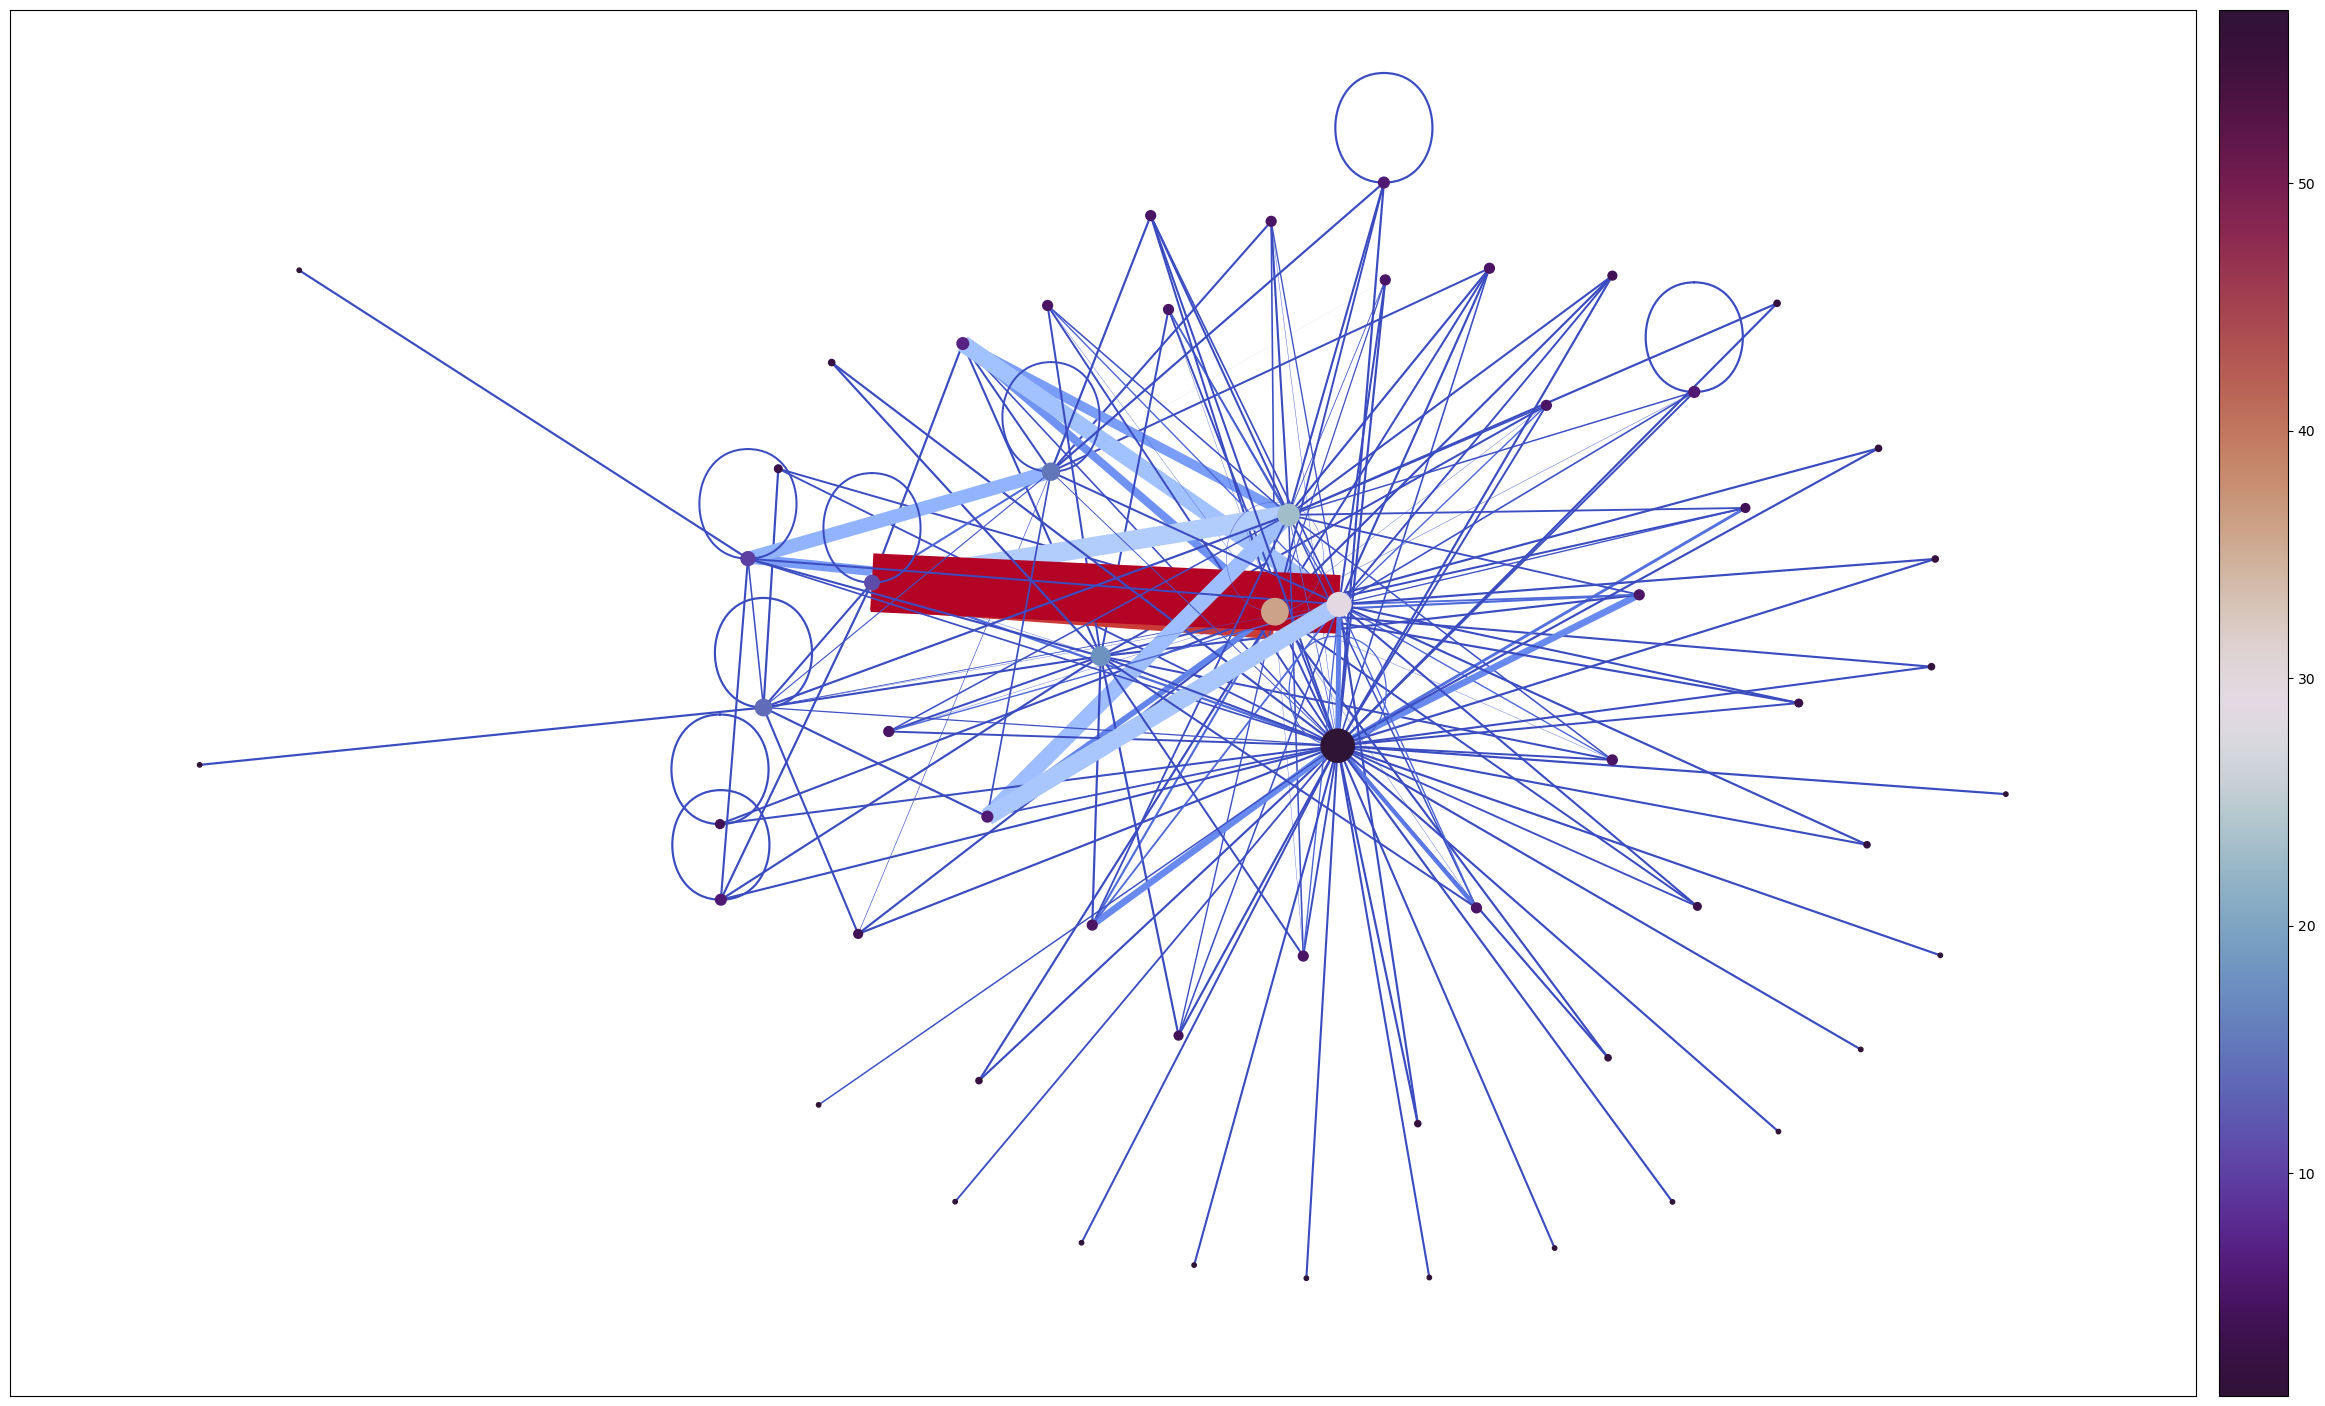

In [31]:
df = pd.DataFrame(index=G.nodes(), columns=G.nodes())
for row, data in nx.shortest_path_length(G):
    for col, dist in data.items():
        df.loc[row,col] = dist

df = df.fillna(df.max().max())
pos = nx.kamada_kawai_layout(G, dim=2, dist=df.to_dict())

low, *_, high = sorted(d.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.twilight_shifted)

plt.figure(figsize =(30, 18))

n = nx.draw_networkx_nodes(G, 
                           pos, 
                           nodelist=[n for n,d in d.items()],
                           node_size=[d*10 for d in d.values()],
                           node_color=[mapper.to_rgba(i) for i in d.values()])

edge_options = {"edge_cmap": plt.cm.coolwarm,
                "arrowstyle": "->",
                "arrowsize": 10}
e = nx.draw_networkx_edges(G,
                           pos,
                           edgelist=[(u,v) for u, v in G.edges()],
                           width=[((G[u][v]['count']-count_mean)/count_std)*5 for u,v in G.edges()],
                           edge_color=[((G[u][v]['count']-count_mean)/count_std)*5 for u,v in G.edges()],
                           **edge_options)

mapper.set_array(sorted(d.values()))
plt.colorbar(mapper, fraction=0.05, pad=0.01)
plt.show()

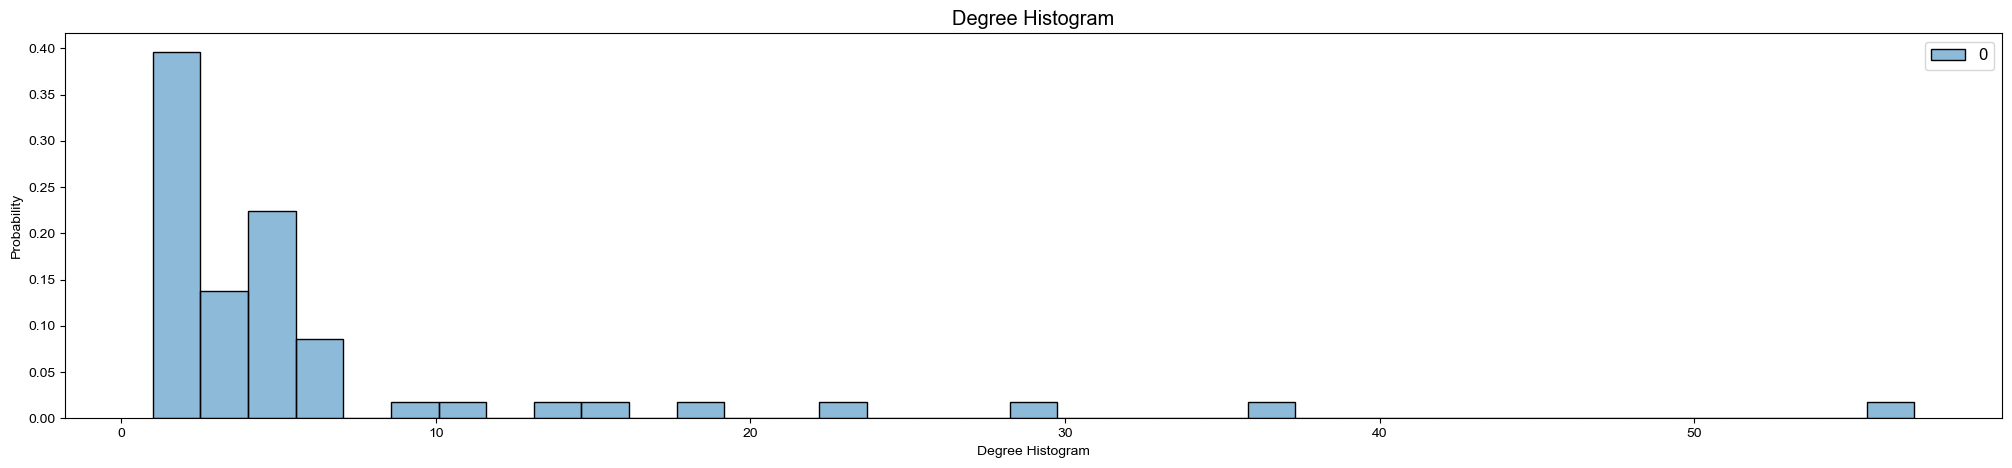

In [32]:
fig, ax = plt.subplots(figsize=(25,5))
plt.rcParams.update({'font.size': 12})

ax = sns.histplot(d.values(), stat='probability', color='blue')

ax.set(xlabel='Degree Histogram')
ax.set_title('Degree Histogram')
custom_style = {'axes.labelcolor': 'black',
                'xtick.color': 'black',
                'ytick.color': 'black'}
ax = sns.set_style("darkgrid", rc=custom_style)
plt.show()

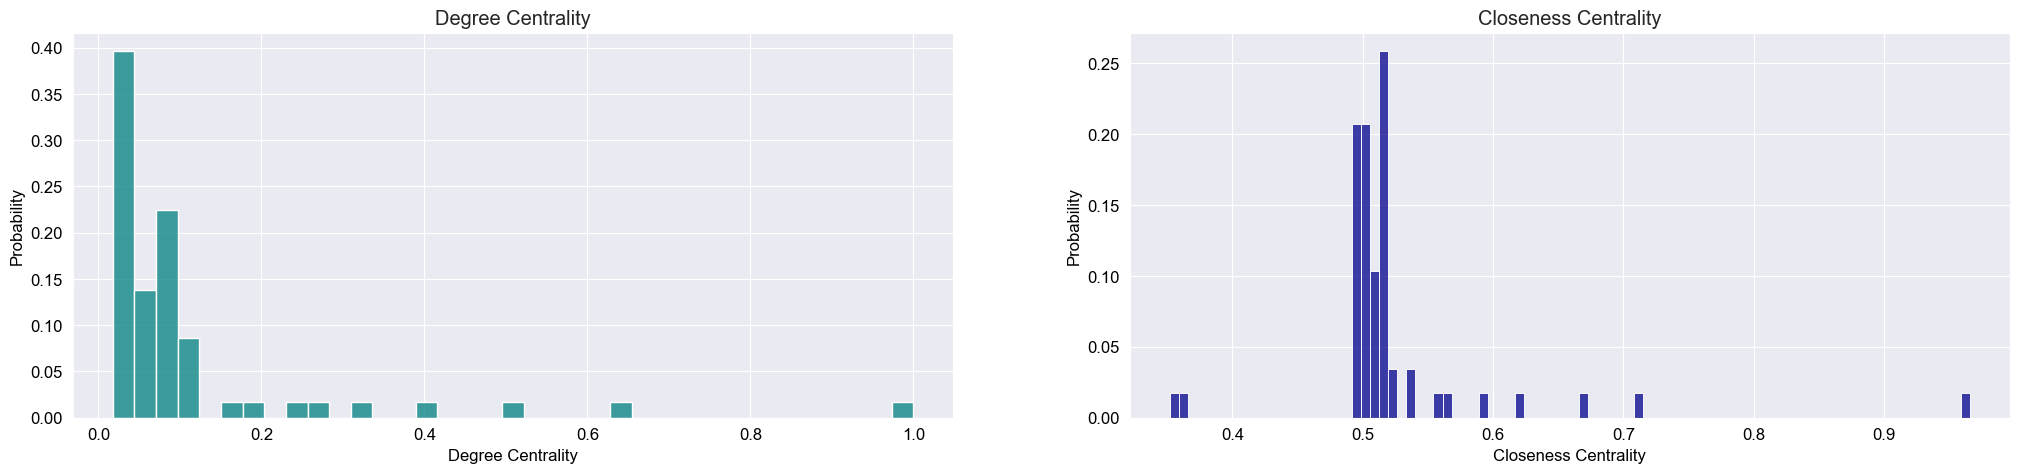

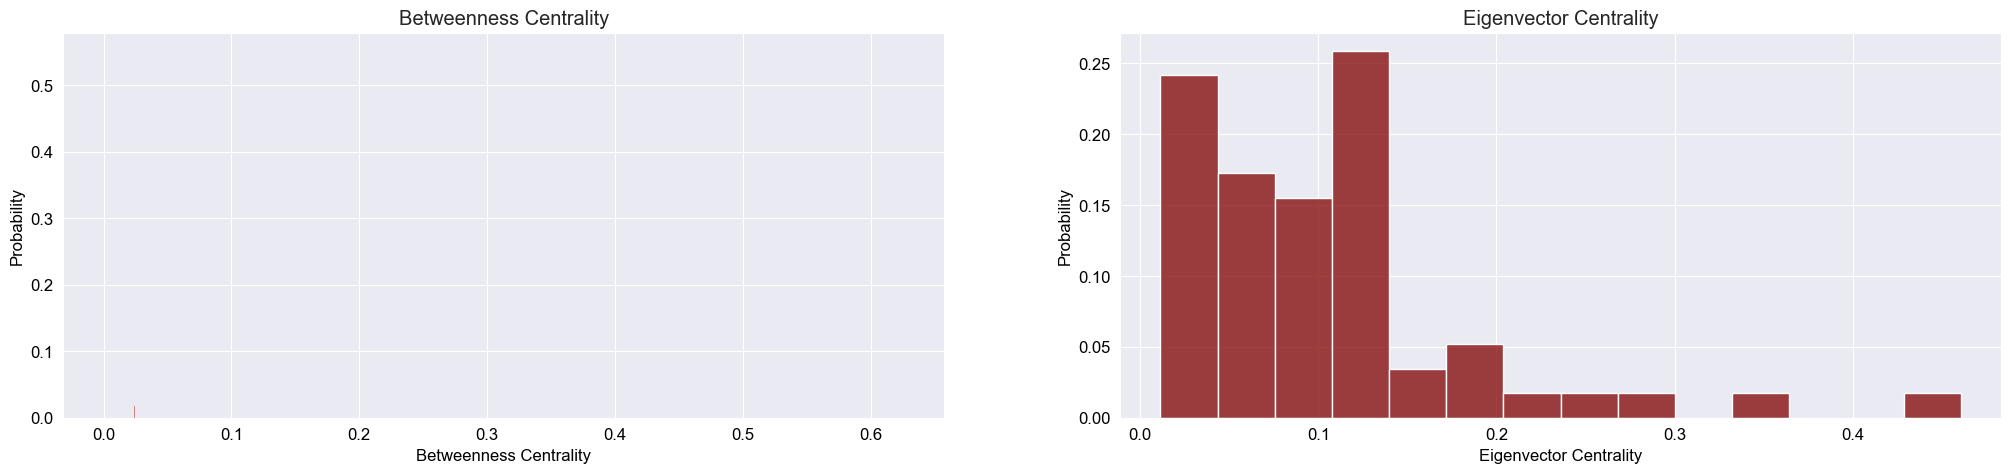

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25, 5))
plt.rcParams.update({'font.size': 12})


ax1 = sns.histplot(metric_main_df, x='Degree Centrality', stat='probability', color='teal', ax=ax1)
ax2 = sns.histplot(metric_main_df, x='Closeness Centrality', stat='probability', color='darkblue', ax=ax2)

ax1.set(xlabel='Degree Centrality')
ax1.set_title('Degree Centrality')
ax2.set(xlabel='Closeness Centrality')
ax2.set_title('Closeness Centrality')
plt.subplots_adjust(hspace = 0.3)

ax1 = sns.set_style("darkgrid", rc=custom_style)
ax2 = sns.set_style("darkgrid", rc=custom_style)
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25, 5))
plt.rcParams.update({'font.size': 12})


ax1 = sns.histplot(metric_main_df, x='Betweenness Centrality', stat='probability', color='indianred', ax=ax1)
ax2 = sns.histplot(metric_main_df, x='Eigenvector Centrality', stat='probability', color='maroon', ax=ax2)

ax1.set(xlabel='Betweenness Centrality')
ax1.set_title('Betweenness Centrality')
ax2.set(xlabel='Eigenvector Centrality')
ax2.set_title('Eigenvector Centrality')
plt.subplots_adjust(hspace = 0.3)

ax = sns.set_style("darkgrid", rc=custom_style)
plt.show()

In [34]:
def CreateDataFrameForCentralityMeasures(dataframe, centrality_measure):

    data = dataframe.sort_values(by=centrality_measure, ascending=True)[centrality_measure].reset_index().rename(columns={'index': 'Country'})
    data = data[data[centrality_measure]>0]

    fig, ax = plt.subplots(figsize=(25,5))
    pal = sns.color_palette('inferno', len(data))
    rank = data[centrality_measure].argsort().argsort()
    ax = sns.barplot(data=data[-15:], x=centrality_measure, y='Country', color=centrality_measure, palette=np.array(pal[::-1])[rank])
    
    plt.show()

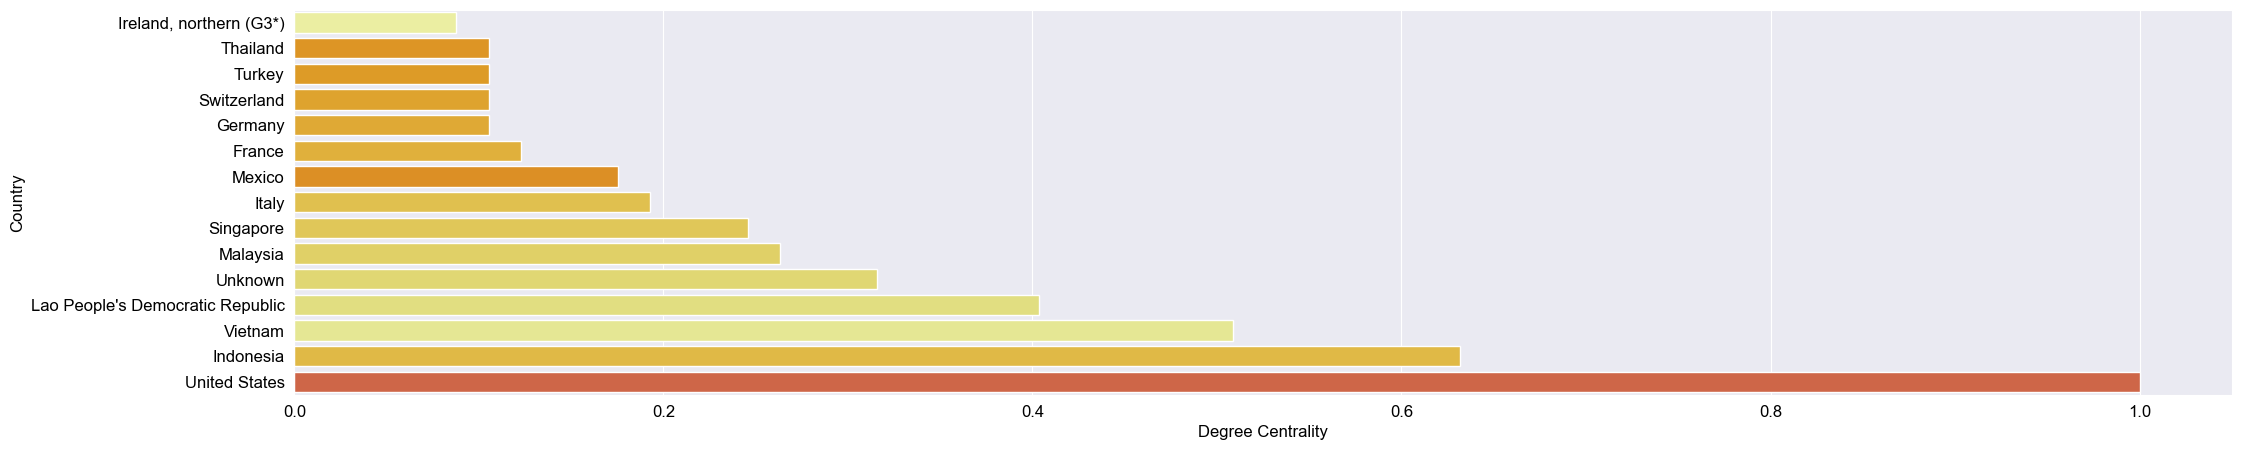

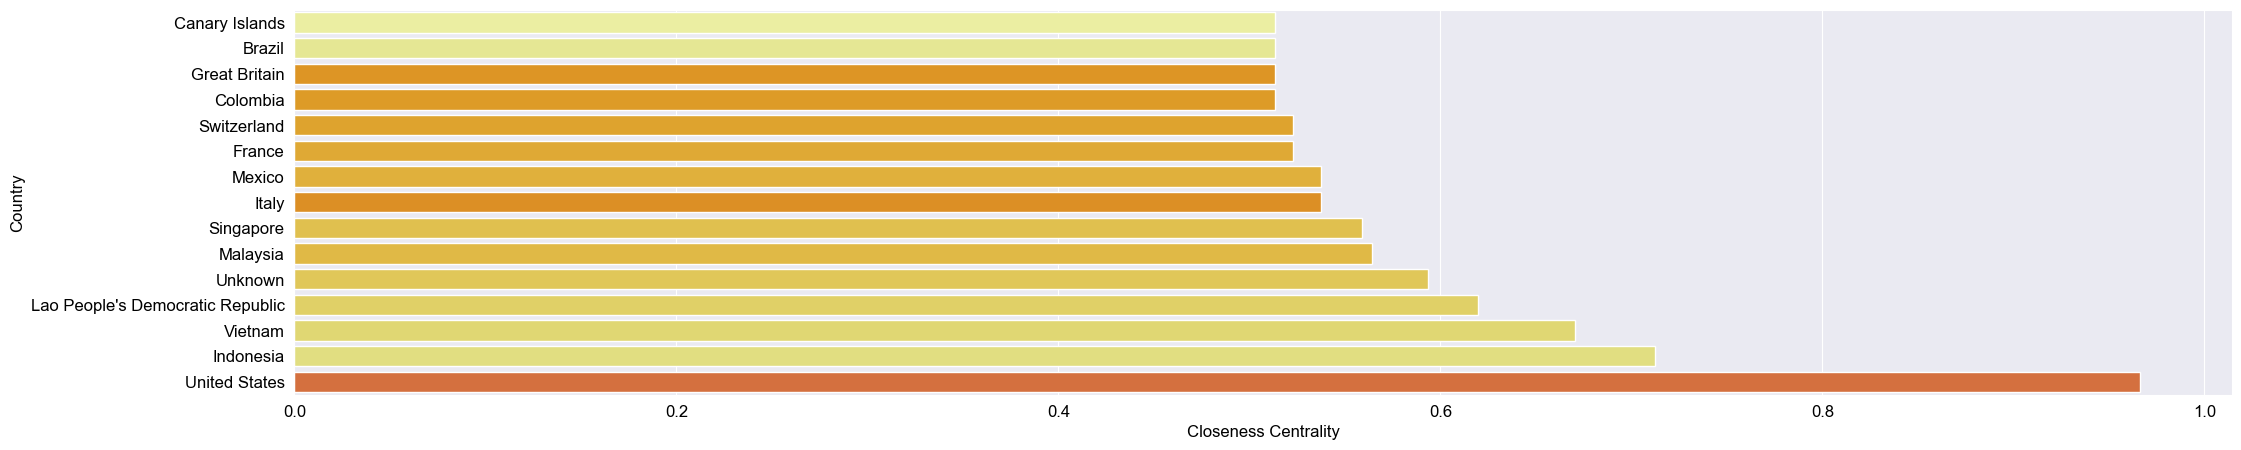

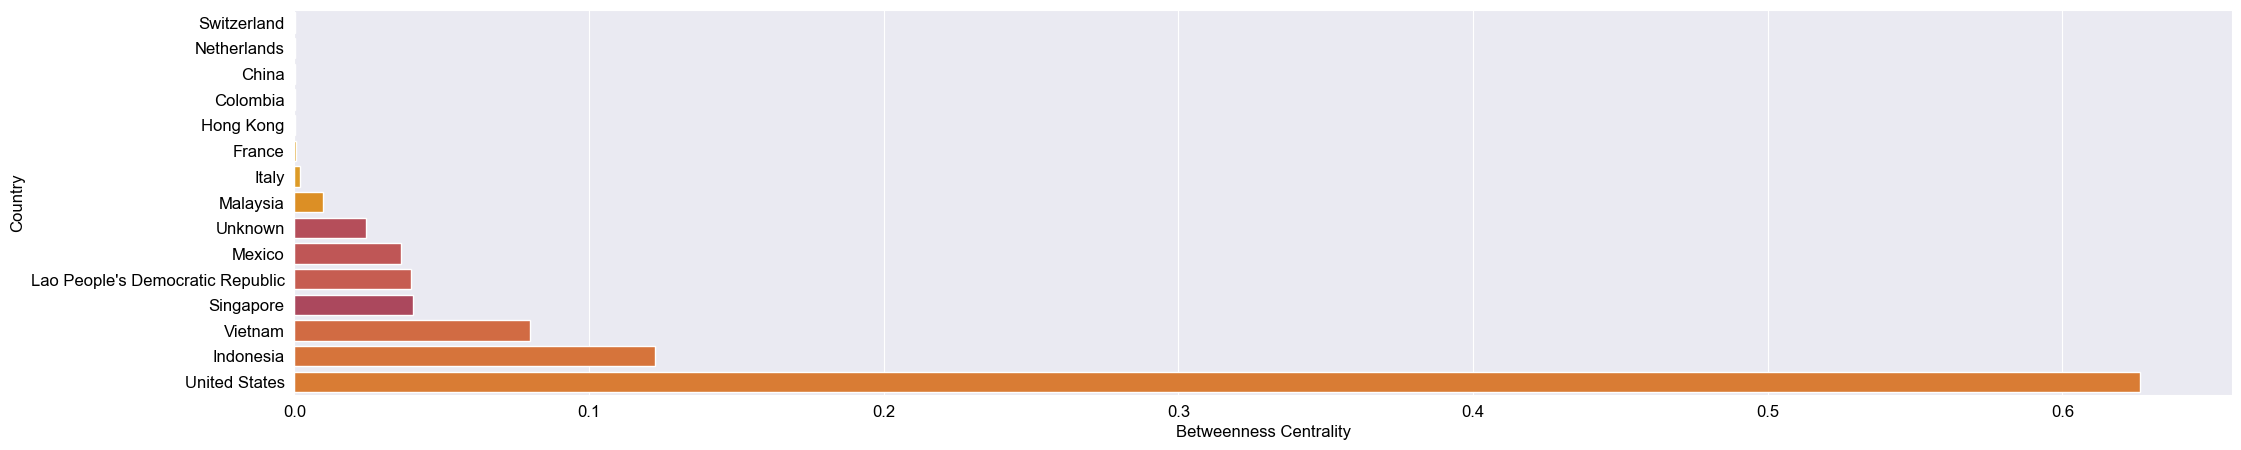

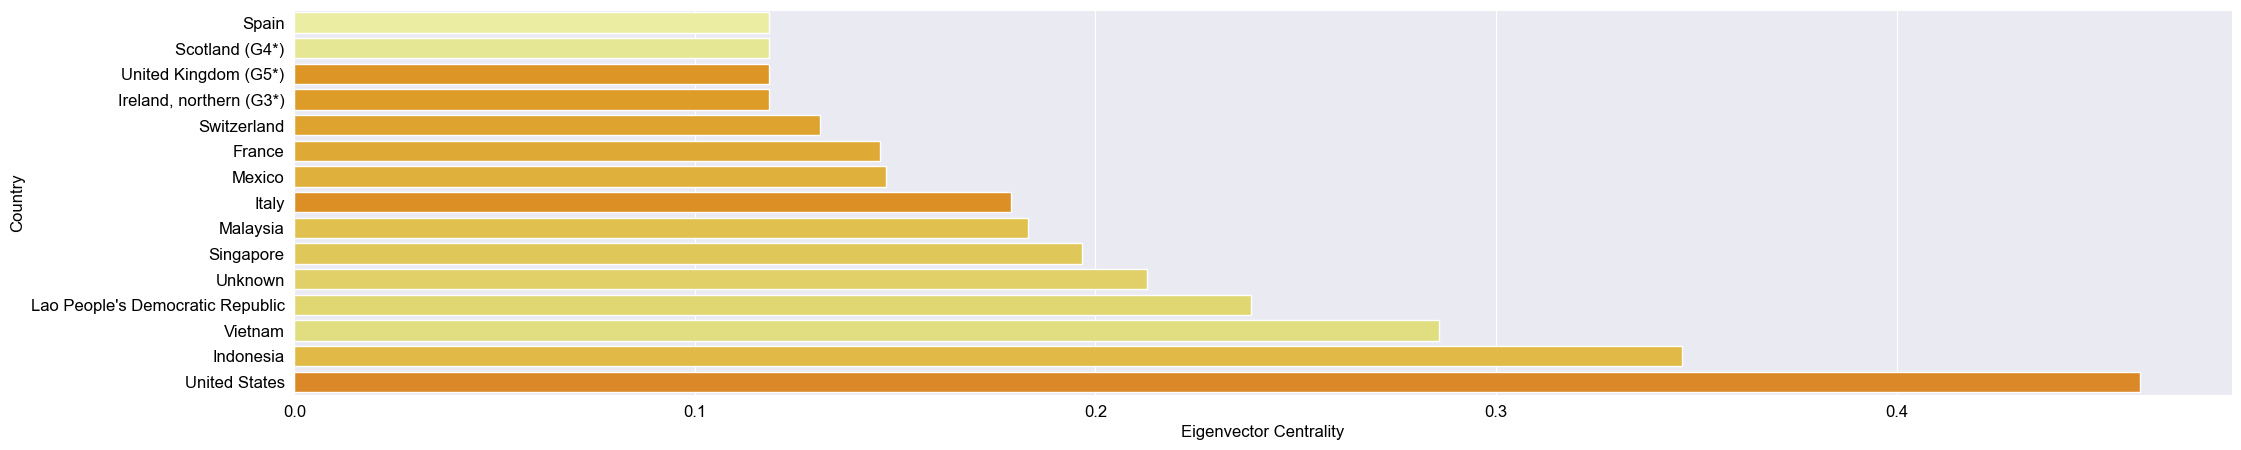

In [35]:
for centrality in ['Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality', 'Eigenvector Centrality']:
    CreateDataFrameForCentralityMeasures(metric_main_df, centrality)

In [58]:
reticulatus.columns

Index(['species_code', 'genus', 'species', 'sub_species', 'specific_name',
       'generic_name', 'disposition_date', 'shipment_date', 'import_export',
       'transport_mode_value', 'us_co', 'action_value', 'description_value',
       'disposition_value', 'port_value', 'purpose_value', 'source_value',
       'country_origin_value', 'country_intermediate_value', 'centimeters',
       'cubic_centimeters', 'cubic_meters', 'grams', 'kilograms', 'liters',
       'meters', 'milligrams', 'milliliters', 'number_of_specimens',
       'square_centimeter', 'square_meters', 'unknown_unit_value',
       'country_destination_value', 'final_disposition'],
      dtype='object')

In [83]:
bn_df = reticulatus[['country_origin_value', 'country_intermediate_value', 'country_destination_value', 'final_disposition']].reset_index(drop=True)
bn_df

country_origin_value country_intermediate_value  \
0                             Malaysia                     Mexico   
1                            Indonesia                      Italy   
2                              Vietnam                      Italy   
3                              Vietnam                      Italy   
4                              Vietnam                      Italy   
...                                ...                        ...   
4930                           Vietnam              United States   
4931                         Indonesia              United States   
4932                           Vietnam              United States   
4933                           Vietnam              United States   
4934  Lao People's Democratic Republic              United States   

     country_destination_value final_disposition  
0                United States           Cleared  
1                United States           Cleared  
2                United States           Cleared  
3                United States           Cleared  
4                United States           Cleared  
...                        ...               ...  
4930                 Singapore           Cleared  
4931                 Singapore           Cleared  
4932                     Italy           Cleared  
4933                 Singapore           Cleared  
4934                    Canada           Cleared  

[4935 rows x 4 columns]

In [86]:
# bn_df['refused'] = np.where(bn_df['final_disposition'] == 'Refused', 1, 0)
# bn_df = bn_df.drop(columns=['final_disposition', 'generic_name'])
bn_model_df = pd.get_dummies(bn_df[['country_origin_value', 'country_intermediate_value', 'country_destination_value']], prefix=['origin', 'intermediate', 'destination'])
bn_model_df = bn_model_df.join(bn_df['final_disposition'], how='inner')
bn_model_df['final_disposition'] = np.where(bn_model_df['final_disposition'] == 'Refused', 1, 0)
bn_model_df.head()

origin_Germany  origin_Guyana  origin_Indonesia  origin_Italy  \
0               0              0                 0             0   
1               0              0                 1             0   
2               0              0                 0             0   
3               0              0                 0             0   
4               0              0                 0             0   

   origin_Lao People's Democratic Republic  origin_Malaysia  origin_Mexico  \
0                                        0                1              0   
1                                        0                0              0   
2                                        0                0              0   
3                                        0                0              0   
4                                        0                0              0   

   origin_Philippines  origin_Singapore  origin_Thailand  ...  \
0                   0                 0                0  ...   
1                   0                 0                0  ...   
2                   0                 0                0  ...   
3                   0                 0                0  ...   
4                   0                 0                0  ...   

   destination_Singapore  destination_South Africa  destination_Switzerland  \
0                      0                         0                        0   
1                      0                         0                        0   
2                      0                         0                        0   
3                      0                         0                        0   
4                      0                         0                        0   

   destination_Taiwan (Province of China)  destination_Turkey  \
0                                       0                   0   
1                                       0                   0   
2                                       0                   0   
3                                       0                   0   
4                                       0                   0   

   destination_United Arab Emirates  destination_United Kingdom (G5*)  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 0                                 0   

   destination_United States  destination_Wales (G6*)  final_disposition  
0                          1                        0                  0  
1                          1                        0                  0  
2                          1                        0                  0  
3                          1                        0                  0  
4                          1                        0                  0  

[5 rows x 96 columns]

In [88]:
sm = from_pandas(bn_model_df, w_threshold=0.8)

In [89]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp',
)
Image(viz.draw(format='png'))

In [90]:
bayesnet = BayesianNetwork(sm)

In [92]:
bn_model_df.head()

origin_Germany  origin_Guyana  origin_Indonesia  origin_Italy  \
0               0              0                 0             0   
1               0              0                 1             0   
2               0              0                 0             0   
3               0              0                 0             0   
4               0              0                 0             0   

   origin_Lao People's Democratic Republic  origin_Malaysia  origin_Mexico  \
0                                        0                1              0   
1                                        0                0              0   
2                                        0                0              0   
3                                        0                0              0   
4                                        0                0              0   

   origin_Philippines  origin_Singapore  origin_Thailand  ...  \
0                   0                 0                0  ...   
1                   0                 0                0  ...   
2                   0                 0                0  ...   
3                   0                 0                0  ...   
4                   0                 0                0  ...   

   destination_Singapore  destination_South Africa  destination_Switzerland  \
0                      0                         0                        0   
1                      0                         0                        0   
2                      0                         0                        0   
3                      0                         0                        0   
4                      0                         0                        0   

   destination_Taiwan (Province of China)  destination_Turkey  \
0                                       0                   0   
1                                       0                   0   
2                                       0                   0   
3                                       0                   0   
4                                       0                   0   

   destination_United Arab Emirates  destination_United Kingdom (G5*)  \
0                                 0                                 0   
1                                 0                                 0   
2                                 0                                 0   
3                                 0                                 0   
4                                 0                                 0   

   destination_United States  destination_Wales (G6*)  final_disposition  
0                          1                        0                  0  
1                          1                        0                  0  
2                          1                        0                  0  
3                          1                        0                  0  
4                          1                        0                  0  

[5 rows x 96 columns]

In [93]:
train, test = train_test_split(bn_model_df, train_size=0.9, test_size=0.1, random_state=0)

In [94]:
bayesnet = bayesnet.fit_node_states(bn_model_df)
bayesnet = bayesnet.fit_cpds(train, method='BayesianEstimator', bayes_prior='K2')

ValueError: Product space too large to allocate arrays!

In [54]:
bn_manual_df = bn_df.copy()
bn_manual_df['country_origin_value'] = bn_manual_df['country_origin_value'].apply(lambda x: f'origin_{x}')
bn_manual_df['country_intermediate_value'] = bn_manual_df['country_intermediate_value'].apply(lambda x: f'intermediate_{x}')
bn_manual_df['country_destination_value'] = bn_manual_df['country_destination_value'].apply(lambda x: f'destination_{x}')
bn_manual_df = bn_manual_df[['country_origin_value', 'country_intermediate_value']].rename(columns={'country_origin_value':'from', 'country_intermediate_value':'to'}).append(
    bn_manual_df[['country_intermediate_value', 'country_destination_value']].rename(columns={'country_intermediate_value':'from', 'country_destination_value':'to'}), ignore_index=True)

edges = list(zip(bn_manual_df['from'], bn_manual_df['to']))

[bnlearn] >bayes DAG created.
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


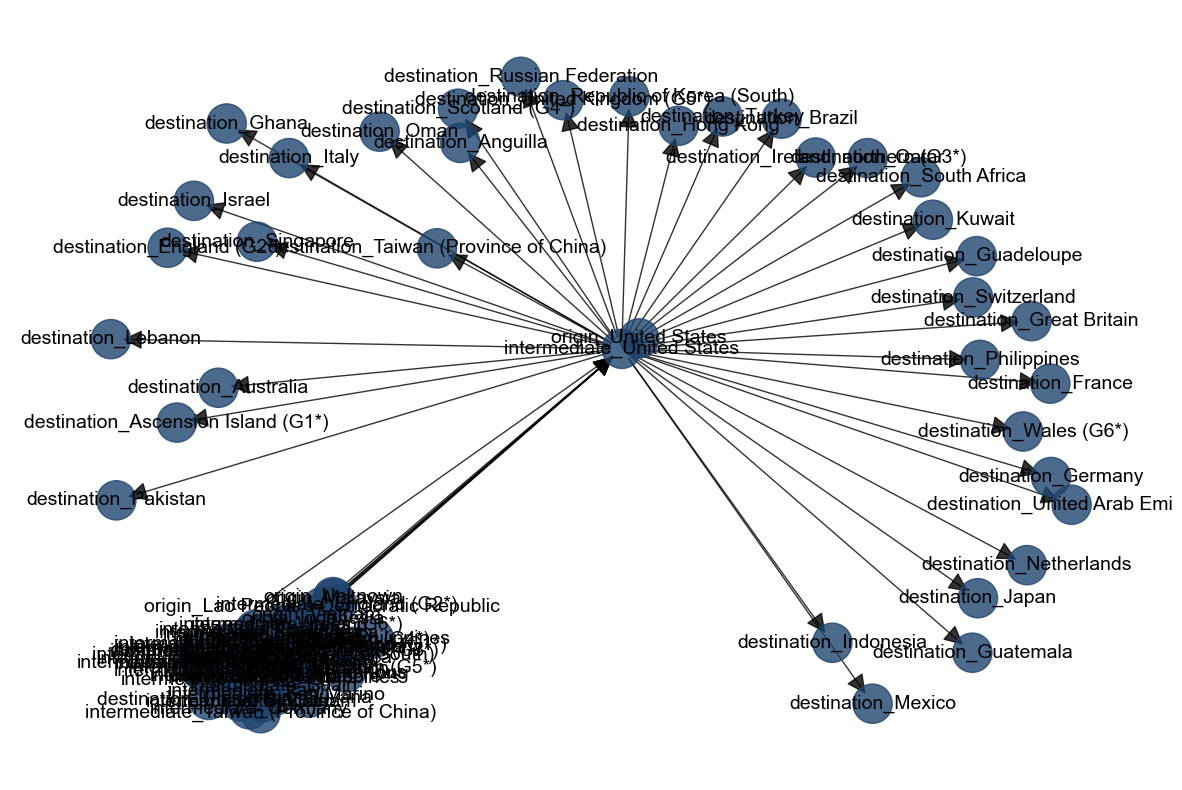

In [55]:
DAG = bn.make_DAG(edges)
G_dag = bn.plot(DAG)

In [57]:
model_hc_bic = bn.structure_learning.fit(bn_model_df, methodtype='hc', scoretype='bic')
model_hc_bic1 = bn.independence_test(model_hc_bic, bn_model_df, alpha=0.05, prune=False)

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute edge strength with [chi_square]


[bnlearn] >Set node properties.
[bnlearn]> Set edge weights based on the [chi_square] test statistic.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


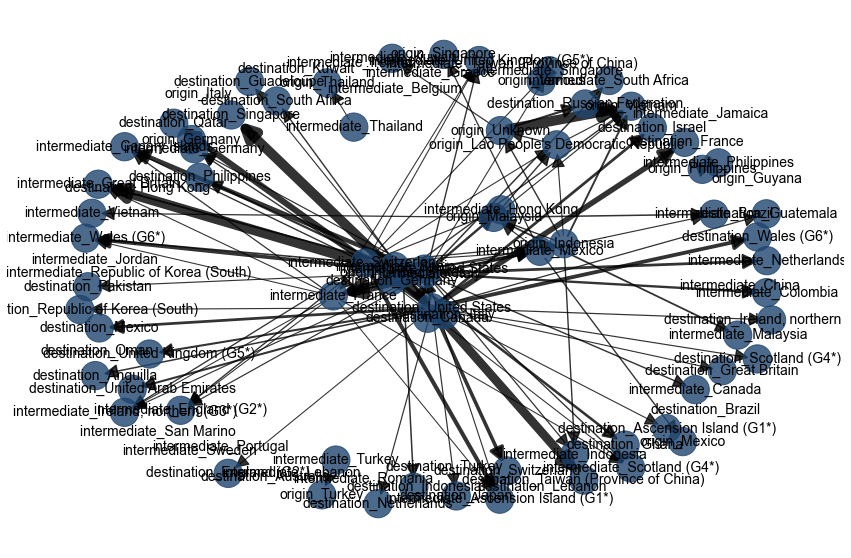

In [58]:
G_bn = bn.plot(model_hc_bic1)

In [59]:
# 'hc' or 'hillclimbsearch'
# model_hc_k2 = bn.structure_learning.fit(bn_df, methodtype='hc', scoretype='k2')
# model_hc_k21 = bn.independence_test(model_hc_k2, bn_df, alpha=0.05, prune=False)
# model_hc_bdeu = bn.structure_learning.fit(bn_df, methodtype='hc', scoretype='bdeu')
# model_hc_bdeu1 = bn.independence_test(model_hc_bdeu, bn_df, alpha=0.05, prune=False)

# # 'ex' or 'exhaustivesearch'
# model_ex_bic = bn.structure_learning.fit(bn_df, methodtype='ex', scoretype='bic')
# model_ex_bic1 = bn.independence_test(model_ex_bic, bn_df, alpha=0.05, prune=False)
# model_ex_k2 = bn.structure_learning.fit(bn_df, methodtype='ex', scoretype='k2')
# model_ex_k21 = bn.independence_test(model_ex_k2, bn_df, alpha=0.05, prune=False)
# model_ex_bdeu = bn.structure_learning.fit(bn_df, methodtype='ex', scoretype='bdeu')
# model_ex_bdeu1 = bn.independence_test(model_ex_bdeu, bn_df, alpha=0.05, prune=False)

# # 'cs' or 'constraintsearch'
# model_cs_k2 = bn.structure_learning.fit(bn_df, methodtype='cs', scoretype='k2')
# model_cs_k21 = bn.independence_test(model_cs_k2, bn_df, alpha=0.05, prune=False)
# model_cs_bdeu = bn.structure_learning.fit(bn_df, methodtype='cs', scoretype='bdeu')
# model_cs_bdeu1 = bn.independence_test(model_cs_bdeu, bn_df, alpha=0.05, prune=False)
# model_cs_bic = bn.structure_learning.fit(bn_df, methodtype='cs', scoretype='bic')
# model_cs_bic1 = bn.independence_test(model_cs_bic, bn_df, alpha=0.05, prune=False)

# # 'cl' or 'chow-liu'
# model_cl = bn.structure_learning.fit(bn_df, methodtype='cl', root_node='refused')
# model_cl1 = bn.independence_test(model_cl, bn_df, alpha=0.05, prune=False)

In [60]:
# G_bn2 = bn.plot(model_ex_bic1)

In [61]:
# G_bn3 = bn.plot(model_cs_bic1)

In [62]:
bn_model_df

origin_Germany  origin_Guyana  origin_Indonesia  origin_Italy  \
0                  0              0                 0             0   
1                  0              0                 1             0   
2                  0              0                 0             0   
3                  0              0                 0             0   
4                  0              0                 0             0   
...              ...            ...               ...           ...   
4930               0              0                 0             0   
4931               0              0                 1             0   
4932               0              0                 0             0   
4933               0              0                 0             0   
4934               0              0                 0             0   

      origin_Lao People's Democratic Republic  origin_Malaysia  origin_Mexico  \
0                                           0                1              0   
1                                           0                0              0   
2                                           0                0              0   
3                                           0                0              0   
4                                           0                0              0   
...                                       ...              ...            ...   
4930                                        0                0              0   
4931                                        0                0              0   
4932                                        0                0              0   
4933                                        0                0              0   
4934                                        1                0              0   

      origin_Philippines  origin_Singapore  origin_Thailand  ...  \
0                      0                 0                0  ...   
1                      0                 0                0  ...   
2                      0                 0                0  ...   
3                      0                 0                0  ...   
4                      0                 0                0  ...   
...                  ...               ...              ...  ...   
4930                   0                 0                0  ...   
4931                   0                 0                0  ...   
4932                   0                 0                0  ...   
4933                   0                 0                0  ...   
4934                   0                 0                0  ...   

      destination_Scotland (G4*)  destination_Singapore  \
0                              0                      0   
1                              0                      0   
2                              0                      0   
3                              0                      0   
4                              0                      0   
...                          ...                    ...   
4930                           0                      1   
4931                           0                      1   
4932                           0                      0   
4933                           0                      1   
4934                           0                      0   

      destination_South Africa  destination_Switzerland  \
0                            0                        0   
1                            0                        0   
2                            0                        0   
3                            0                        0   
4                            0                        0   
...                        ...                      ...   
4930                         0                        0   
4931                         0                        0   
4932                         0                        0   
4933                         0                        0   
4934 

In [71]:
bayesian_network_model = BayesianNetwork(edges)
bayesian_network_model_mle = bayesian_network_model.fit(bn_model_df, estimator=MaximumLikelihoodEstimator)
bayesian_network_model_mle.get_cpds()

MemoryError: Unable to allocate 4.00 TiB for an array with shape (4398046511104,) and data type int8

In [65]:
bn_model_df.sample(frac=.5).shape

(2468, 95)

In [72]:
# Parameter learning on the user-defined DAG and input data using maximumlikelihood
model_mle = bn.parameter_learning.fit(DAG, bn_model_df, methodtype='maximumlikelihood', n_jobs=6)

[bnlearn] >Parameter learning> Computing parameters using [maximumlikelihood]


MemoryError: Unable to allocate 4.00 TiB for an array with shape (4398046511104,) and data type int8

In [65]:
bn.print_CPD(model_mle)

NameError: name 'model_mle' is not defined

In [43]:
# Parameter learning on the user-defined DAG and input data using Bayes
model_bayes = bn.parameter_learning.fit(DAG, bn_model_df, methodtype='bayes')

[bnlearn] >Parameter learning> Computing parameters using [bayes]


MemoryError: Unable to allocate 512. PiB for an array with shape (576460752303423488,) and data type int8

In [ ]:
bn.print_CPD(model_bayes)